## Project 2 - Bee Subspecie Classification (CNNs)

**Objectives**:  Build a Deep Learning algorithm using Keras for a Bee subspecies classification.


### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import relevant libraries

In [5]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Import relevant libraries
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, MaxPool2D
from keras.models import Model, Sequential 
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.losses import *
from keras.metrics import *
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from keras.utils.np_utils import to_categorical
import pandas as pd
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split, learning_curve
%matplotlib inline

size = 100 #Desired size of columns and rows of each image (size*size) - We also used 50x50 and 256x256 for some tests
img_class_threshold = 500 #Minimum amount of images from each class

###  Load the data

**Details of the Oversampled "Bees" dataset**:
- Images are of shape (100x100x3)
- Training: 2004 pictures
- Test: 501 pictures

In [6]:
# -----------------------------------
# Loading of the data from the .csv

ds = pd.read_csv('/content/drive/MyDrive/oversampled_balanced_ml_data_rgb.csv')
features=ds['features']
y1=ds['class']

# -----------------------------------
# Mapping the labels to integers from the dictionary

y2 = {'-1': 0, 'Italian honey bee':1,'Carniolan honey bee':2, 'Russian honey bee':3,'1 Mixed local stock 2':4}
y = (pd.Series(y1)).map(y2)
y = np.array(y)
y = np.reshape(y, (-1, 1))


#print(type(y))
#print(y)
n_examples = features.shape[0]
feature_size = size*size

X = np.empty((n_examples,size,size,3), float)
for idx,f in enumerate(features):
        arr_f = np.fromstring(f, dtype=float, sep=' ')
        arr_f = np.reshape(arr_f,(3,size,size)).transpose(1,2,0)
        X[idx,:] = np.copy(arr_f)

# -----------------------------------
# Split of the data
# 3 Methods used - choose 1 only

# 80%/20% Holdout Method 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, stratify=y)

# 70%/30% Holdout Method 

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# 3 way split: Train/Dev/Test Sets
# As we use a small data set (up to 10000 examples) we will use this division: 60%/20%/20%
# One approach to dividing the dataset into train, test, cv with 0.6, 0.2, 0.2 is to use the train_test_split method twice like below.

#X, X_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)
#X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.25,train_size =0.75)

# -----------------------------------

# Informations about the shapes
print('X_train.shape: ' + str(X_train.shape))
print('y_train.shape: ' + str(y_train.shape))
print('X_test.shape: ' + str(X_test.shape))
print('y_test.shape: ' + str(y_test.shape))

# -----------------------------------

X_train.shape: (2004, 100, 100, 3)
y_train.shape: (2004, 1)
X_test.shape: (501, 100, 100, 3)
y_test.shape: (501, 1)


### Building a model in Keras

Here is an example of a model in Keras that we based on:

```python
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    #Think of this as an input image.
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    #Conv2D(filters, kernel_size, .... data_format='channels_last',...)
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    
    #Normalize the activations of the previous layer at each batch, i.e. applies a transformation     that maintains the mean activation close to 0 and activation standard deviation close to 1.
    # If data_format="channels_last", the axis to be normalized is axis=3. 
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL: helps to lower the dimension of X in height and width.
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Creates the Keras model instance (object), you'll use to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

**Objective**: Implement a `BeeModel()`. Vary the network architecture (e.g. add new blocks CONV -> BN -> RELU -> MAXP) or vary the hyperparameters (e.g Conv2D(32, (3, 3),....) ), always being careful with the data's shapes. 

In [ ]:
# BeeModel

def BeeModel(input_shape):
    """
    Implementation of the BeeModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    #Think of this as an input image.
    X_input = Input(input_shape)
   

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)
    #X = Sequential()
    # BLOCK 1: CONV -> BN -> RELU -> MAXP
    X = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', name = 'conv0')(X)
    #X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool0')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(5, activation='softmax', name='fc')(X)
    #X = Dense(1, activation='softmax', name='fc2')(X)

    # Creates the Keras model instance (object), you'll use to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BeeModel')

    return model

### Creating, Training and Evaluating the Model

**Objectives:**
1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model by calling `model.fit(X_train, Y_train, epochs = ..., batch_size = ...)`
4. Evaluate the model by calling `model.evaluate(x = ..., y = ...)`


In [14]:
# 1. Create the model by calling the function above
beeModel = BeeModel((100, 100, 3))


NameError: ignored

In [15]:
# 2.Compile the model to configure the learning process. Choose the arguments of compile() wisely.
#beeModel.compile(optimizer = "sgd", loss='mse', metrics = ["accuracy", "sparse_categorical_accuracy"])
#beeModel.compile(optimizer = "kld", loss='mse', metrics = ["accuracy", "sparse_categorical_accuracy"])
beeModel.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])




In [16]:
# 3.Train the model on train data. Choose the number of epochs and the batch size.
history = beeModel.fit(X_train, y_train, epochs = 20, batch_size = 64)

Epoch 1/15
63/63 [==============================] - 12s 67ms/step - loss: 3.5654 - accuracy: 0.1609
Epoch 2/15
63/63 [==============================] - 4s 67ms/step - loss: 1.5356 - accuracy: 0.2024
Epoch 3/15
63/63 [==============================] - 4s 67ms/step - loss: 1.5656 - accuracy: 0.2030
Epoch 4/15
63/63 [==============================] - 4s 67ms/step - loss: 2.7427 - accuracy: 0.1947
Epoch 5/15
63/63 [==============================] - 4s 66ms/step - loss: 2.2764 - accuracy: 0.1967
Epoch 6/15
63/63 [==============================] - 4s 67ms/step - loss: 2.0878 - accuracy: 0.1949
Epoch 7/15
63/63 [==============================] - 4s 67ms/step - loss: 2.0266 - accuracy: 0.2003
Epoch 8/15
63/63 [==============================] - 4s 67ms/step - loss: 1.8544 - accuracy: 0.1971
Epoch 9/15
63/63 [==============================] - 4s 67ms/step - loss: 2.4595 - accuracy: 0.1943
Epoch 10/15
63/63 [==============================] - 4s 67ms/step - loss: 3.9975 - accuracy: 0.1946
Epoch 11

KeyboardInterrupt: ignored

Note that if you run `fit()` again, the `model` will continue to train with the parameters it has already learned instead of reinitializing them.


In [ ]:
# 4.1 Evaluate the model on train data  
score = beeModel.evaluate(x = X_train, y = y_train)

print ("Loss =  " )
print(score[0])
print (" Accuracy on Train data = " )
print(score[1])

63/63 [==============================] - 0s 5ms/step - loss: 0.0246 - accuracy: 0.9960
Loss =  
0.024588145315647125
 Accuracy on Train data = 
0.9960079789161682


In [ ]:
# 4.2 Evaluate the model on test data  
score = beeModel.evaluate(x = X_test, y = y_test)

print ("Loss =  " )
print(score[0])
print (" Accuracy on Test data = " )
print(score[1])

16/16 [==============================] - 0s 6ms/step - loss: 0.1242 - accuracy: 0.9661
Loss =  
0.12418705970048904
 Accuracy on Test data = 
0.9660678505897522


### Increasing accuracy of the model

In [ ]:
#Prints the details of your layers in a table with the sizes of its inputs/outputs
beeModel.summary()


Model: "BeeModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 zero_padding2d_19 (ZeroPadd  (None, 106, 106, 3)      0         
 ing2D)                                                          
                                                                 
 conv0 (Conv2D)              (None, 106, 106, 16)      448       
                                                                 
 activation_19 (Activation)  (None, 106, 106, 16)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 53, 53, 16)        0         
                                                                 
 flatten_19 (Flatten)        (None, 44944)             0         
                                                          

### Testing the model with the test set

Classification Report:
                       precision    recall  f1-score   support

    Italian honey bee       0.93      0.92      0.93        91
  Carniolan honey bee       0.95      0.96      0.96       110
    Russian honey bee       0.96      1.00      0.98       109
1 Mixed Local Stock 2       0.99      0.98      0.98        91
    Unknow subspecies       0.99      0.96      0.97       100

             accuracy                           0.97       501
            macro avg       0.97      0.96      0.97       501
         weighted avg       0.97      0.97      0.97       501

----------------------
Confusion Matrix:
[[ 84   3   3   1   0]
 [  3 106   0   0   1]
 [  0   0 109   0   0]
 [  1   0   1  89   0]
 [  2   2   0   0  96]]
----------------------
Confusion Matrix Display:


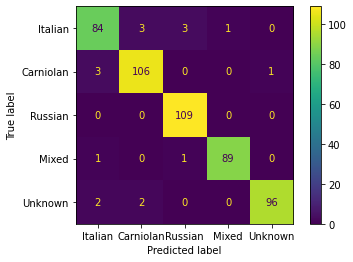

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`

pred = beeModel.predict(X_test)
# Classification report - here we get a lot of metrics such as the precision, recall and f1-score as well as some averages

target_names = ['Italian honey bee', 'Carniolan honey bee', 'Russian honey bee', '1 Mixed Local Stock 2', 'Unknow subspecies']
print("Classification Report:")
predicted = np.argmax(pred, axis=1)
print(classification_report(y_test, predicted, target_names=target_names))

# Confusion Matrix
print("----------------------")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, predicted) #,normalize='all')
print(cm)
print("----------------------")
display_labels = ['Italian', 'Carniolan', 'Russian', 'Mixed', 'Unknown']

# This graphically computes the confusion matrix for better visualization

print("Confusion Matrix Display:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp.plot()

plt.show()

#print(beeModel.predict(X_test))


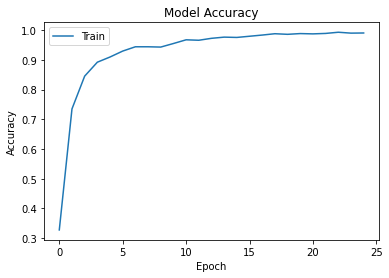

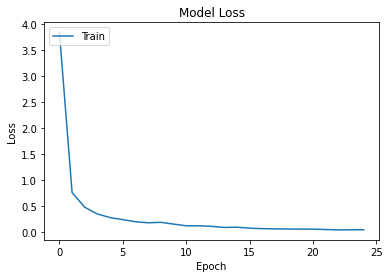

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()